In [62]:
import pandas as pd
import numpy as np
from read_path_module import read_data_relative_path
from write_path_module import write_data_relative_path
import matplotlib.pyplot as plt

# Set Matplotlib default text sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

### - Import the dataset

In [28]:
df = read_data_relative_path('./data/CDC_Natality/2003_2018.csv', data_type='csv')
df['Birth Date'] = pd.to_datetime(df['Birth Date'])
df['Conception Date'] = pd.to_datetime(df['Conception Date']).dt.normalize()
df.sample(2)

,Birth Year,Conception Year,Conception Year Standard,Birth Month,Conception Month,Conception Month Standard,Birth Month Code,Conception Month Code,Conception Month Code Standard,Birth Date,...,Conception Date Standard,State,State Acronym,State Code,County,County Code,Births,Average Age of Mother,Average LMP Gestational Age,Notes
94679,2016,2015,2015,July,November,October,7,11,10,2016-07-15,...,2015-10-23 00:00:00.000000000,North Carolina,NC,37,Gaston County,37071,227.0,27.03,38.46,NaN
97,2003,2002,2002,January,May,April,1,5,4,2003-01-15,...,2002-04-24 00:00:00.000000000,Florida,FL,12,Escambia County,12033,353.0,25.71,38.52,NaN


### - Get unique list of county codes

In [29]:
lst_county_codes = list(df['County Code'].unique())
lst_state_codes = list(df['State Code'].unique())

### - Births per county over time (Line)

In [47]:
def Random_Plotter(df, geography='county', metric='birth'):
    
    # Initiate a figure
    fig= plt.figure()

    # Randomly select a state or county and define a new dataframe
    import random 
    if geography.lower() == 'county':
        lst_county_codes = list(df['County Code'].unique())
        n = random.randrange(0, len(lst_county_codes))
        df_plot = df[df['County Code']==lst_county_codes[n]]
        plt.title(df_plot['County'].to_list()[0] + ', ' + df_plot['State Acronym'].to_list()[0], size = BIGGER_SIZE)
        
    elif geography.lower() == 'state':
        lst_state_codes = list(df['State Code'].unique())
        n = random.randrange(0, len(lst_state_codes))
        df_plot = df[df['State Code']==lst_state_codes[n]]
        df_plot = df_plot.groupby(['State','Birth Year', 'Birth Month', 'Birth Month Code', 'Conception Year Standard', 'Conception Month Code Standard']).agg({'Births': 'sum'}).reset_index()
        df_plot.sort_values(by=['Birth Year', 'Birth Month Code'], inplace = True)

        df_plot['Birth Date'] = pd.to_datetime(df_plot['Birth Year'].astype(str) + '-' + df_plot['Birth Month Code'].astype(str) + '-' + '15', format='%Y-%m-%d')
        df_plot['Conception Date'] = pd.to_datetime(df_plot['Conception Year Standard'].astype(str) + '-' + df_plot['Conception Month Code Standard'].astype(str) + '-' + '15', format='%Y-%m-%d')
        plt.title(df_plot['State'].to_list()[0], size = BIGGER_SIZE)
            
    else:
        return ValueError("Type in either 'county' or 'state' for geography")
    

    # If we care about plotting births... Re-index DF with birth date and label axes appropriately
    if metric.lower() == 'birth':
        df_plot.index = df_plot['Birth Date']
        plt.xlabel('Birth Year')
        plt.ylabel('# of Births per Month')
        
    # If we care about plotting conceptions... Re-index DF with conception date and label axes appropriately
    elif metric.lower() == 'conception':
        df_plot.index = df_plot['Conception Date']
        plt.xlabel('Conception Year')
        plt.ylabel('# of Conceptions per Month')

             
    else:
        return ValueError("Type in either 'birth' or 'conception' for metric")

    # Define plot
    df_plot['Births'].plot(figsize=(15,6), legend=True, label='Raw')
    df_plot['Births'].resample("2m").median().plot(figsize=(15,6), legend=True, label='2 Month Median Resample')
    df_plot['Births'].rolling(4).median().plot(figsize=(15,6), legend=True, label='4 Month Rolling Median')

    plt.show()


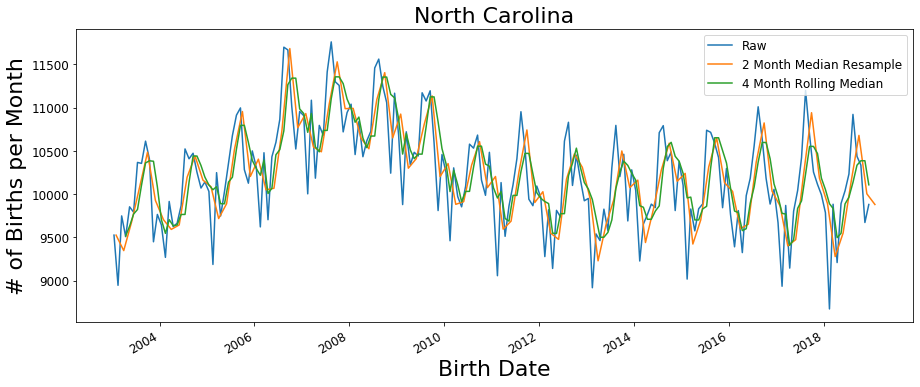

In [48]:
Random_Plotter(df, geography='state', metric='birth')

### - Births per county over each Birth Year (Line)

In [49]:
def Random_Plotter_Annual(df, geography='county', metric='birth'):
    
    # Initiate a figure
    fig= plt.figure(figsize=(20,10))
    
    # Randomly select a state or county and define a new dataframe
    import random 
    if geography.lower() == 'county':
        lst_county_codes = list(df['County Code'].unique())
        n = random.randrange(0, len(lst_county_codes))
        df_plot = df[df['County Code']==lst_county_codes[n]]
        plt.title(df_plot['County'].to_list()[0] + ', ' + df_plot['State Acronym'].to_list()[0], size = BIGGER_SIZE)
        
    elif geography.lower() == 'state':
        lst_state_codes = list(df['State Code'].unique())
        n = random.randrange(0, len(lst_state_codes))
        df_plot = df[df['State Code']==lst_state_codes[n]]
        df_plot = df_plot.groupby(['State','Birth Year', 'Birth Month', 'Birth Month Code', 'Conception Year Standard', 'Conception Month Code Standard']).agg({'Births': 'sum'}).reset_index()
        df_plot.sort_values(by=['Birth Year', 'Birth Month Code'], inplace = True)

        df_plot['Birth Date'] = pd.to_datetime(df_plot['Birth Year'].astype(str) + '-' + df_plot['Birth Month Code'].astype(str) + '-' + '15', format='%Y-%m-%d')
        df_plot['Conception Date'] = pd.to_datetime(df_plot['Conception Year Standard'].astype(str) + '-' + df_plot['Conception Month Code Standard'].astype(str) + '-' + '15', format='%Y-%m-%d')
        plt.title(df_plot['State'].to_list()[0], size = BIGGER_SIZE)
    
    else:
        return ValueError("Type in either 'county' or 'state' for geography")
    
    # If we care about plotting births... 
    if metric.lower() == 'birth':
        
        # Create lst of all years for a given county... Some counties do not span the whole 2003-2018 timeframe
        low = df_plot['Birth Year'].min()
        high = df_plot['Birth Year'].max()
        lst_yrs = list(range(low, high+1))
        
        for yr in lst_yrs:
            x = df_plot[df_plot['Birth Year'] == yr]['Birth Month Code']
            y = df_plot[df_plot['Birth Year'] == yr]['Births']
            plt.plot(x,y)
        plt.ylabel('# of Births per Month')
        plt.xticks(x, labels=df_plot['Birth Month'].unique(), rotation='45', size = MEDIUM_SIZE)

    # If we care about plotting conceptions... 
    elif metric.lower() == 'conception':
        
        # Create lst of all years for a given county... Some counties do not span the whole 2003-2018 timeframe
        low = df_plot['Conception Year'].min()
        high = df_plot['Conception Year'].max()
        lst_yrs = list(range(low, high+1))
        
        for yr in lst_yrs:
            x = df_plot[df_plot['Conception Year Standard'] == yr]['Conception Month Code Standard']
            y = df_plot[df_plot['Conception Year Standard'] == yr]['Births']
            plt.plot(x,y)
        plt.ylabel('# of Conceptions per Month')
             
    else:
        return ValueError("Type in either 'birth' or 'conception' for metric")
    
    plt.show()

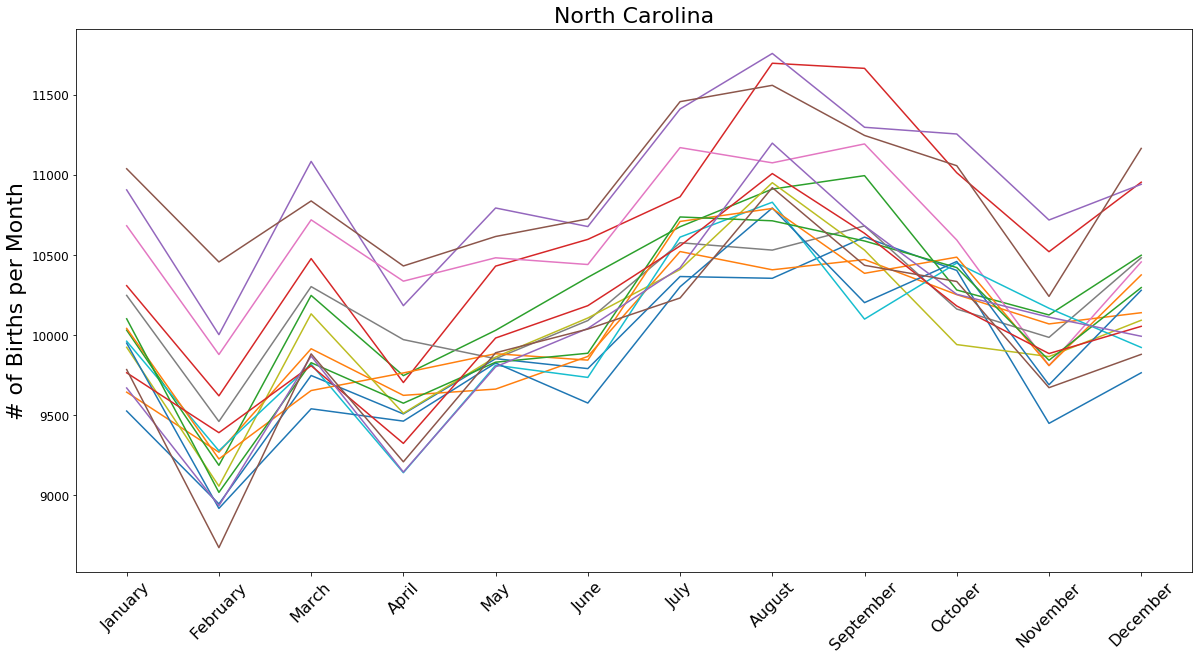

In [50]:
Random_Plotter_Annual(df, geography='state', metric='birth')

In [8]:
# Method for sorting unsorted month labels

    # months = {"January":0, "February":1, "March":2, "April":3, "May":4, "June":5, "July":6, "August":7, "September":8, "October":9, "November":10, "December":11 }
    # def month_value(date):
    #     return months[date]
    # label = list(df_county['Conception Month'].unique())
    # label.sort(key=month_value)

### - Births per county over each Birth Year (Scatter)

In [51]:
def Random_Plotter_Annual_Scatter(df, geography='county', metric='birth'):

    # Initiate a figure
    fig= plt.figure(figsize=(20,8))

    # Randomly select a state or county and define a new dataframe
    import random 
    if geography.lower() == 'county':
        lst_county_codes = list(df['County Code'].unique())
        n = random.randrange(0, len(lst_county_codes))
        df_plot = df[df['County Code']==lst_county_codes[n]]
        plt.title(df_plot['County'].to_list()[0] + ', ' + df_plot['State Acronym'].to_list()[0], size = BIGGER_SIZE)
        
    elif geography.lower() == 'state':
        lst_state_codes = list(df['State Code'].unique())
        n = random.randrange(0, len(lst_state_codes))
        df_plot = df[df['State Code']==lst_state_codes[n]]
        df_plot = df_plot.groupby(['State','Birth Year', 'Birth Month', 'Birth Month Code', 'Conception Year Standard', 'Conception Month Code Standard']).agg({'Births': 'sum'}).reset_index()
        df_plot.sort_values(by=['Birth Year', 'Birth Month Code'], inplace = True)

        df_plot['Birth Date'] = pd.to_datetime(df_plot['Birth Year'].astype(str) + '-' + df_plot['Birth Month Code'].astype(str) + '-' + '15', format='%Y-%m-%d')
        df_plot['Conception Date'] = pd.to_datetime(df_plot['Conception Year Standard'].astype(str) + '-' + df_plot['Conception Month Code Standard'].astype(str) + '-' + '15', format='%Y-%m-%d')
        plt.title(df_plot['State'].to_list()[0], size = BIGGER_SIZE)
    
    else:
        return ValueError("Type in either 'county' or 'state' for geography")
    
    # If we care about plotting births... 
    if metric.lower() == 'birth':
        
        x = df_plot['Birth Month Code']
        y = df_plot['Births']    
        plt.scatter(x, y)
        plt.xticks(x, labels=df_plot['Birth Month'].unique(), rotation='45')
        plt.xlabel('Birth Year')
        plt.ylabel('# of Births per Month')

    # If we care about plotting conceptions... 
    elif metric.lower() == 'conception':
        
#         df_county_mod = df_county.groupby(['Conception Year', 'Conception Month Code']).agg({'Births': 'sum'}).reset_index()
        
#         x = df_county_mod['Conception Month Code']
#         y = df_county_mod['Births']    
        
        x = df_plot['Conception Month Code Standard']
        y = df_plot['Births']  
        
        plt.scatter(x, y)
        plt.xlabel('Conception Year')
        plt.ylabel('# of Conceptions per Month')
             
    else:
        return ValueError("Type in either 'birth' or 'conception' for metric")

#     plt.title(df_plot['County'].to_list()[0] + ', ' + df_plot['State Acronym'].to_list()[0])
    plt.show()

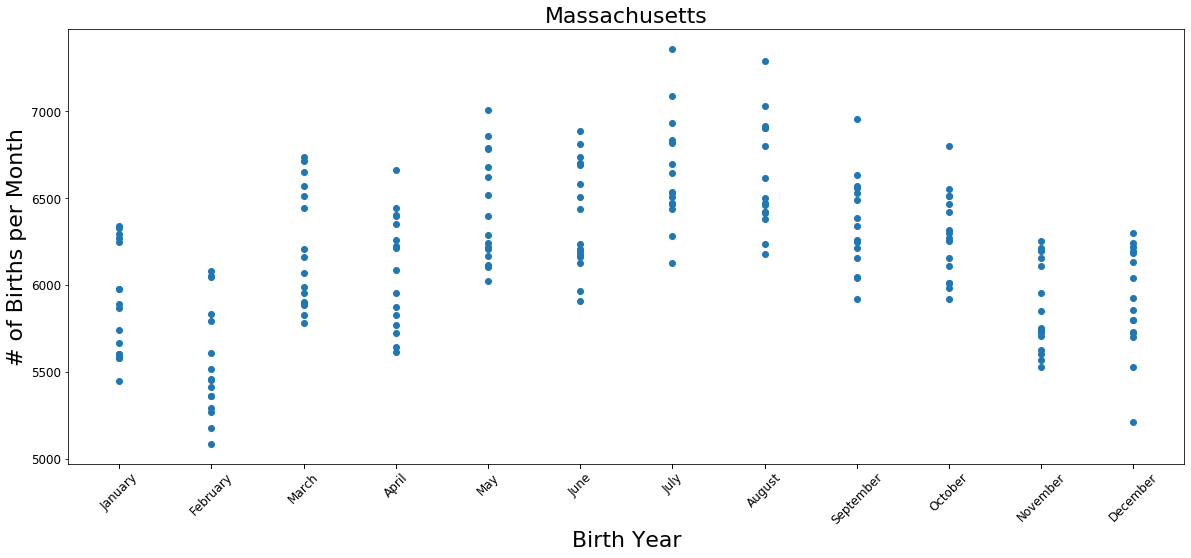

In [52]:
Random_Plotter_Annual_Scatter(df, geography='State', metric = 'birth')

### - Births per county over each Birth Year (Boxplot)

In [60]:
def Random_Plotter_Boxplot(df, geography='county', metric='birth'):
    
    # Randomly select a state or county and define a new dataframe
    import random 
    if geography.lower() == 'county':
        lst_county_codes = list(df['County Code'].unique())
        n = random.randrange(0, len(lst_county_codes))
        df_plot = df[df['County Code']==lst_county_codes[n]]
        
    elif geography.lower() == 'state':
        lst_state_codes = list(df['State Code'].unique())
        n = random.randrange(0, len(lst_state_codes))
        df_plot = df[df['State Code']==lst_state_codes[n]]
        df_plot = df_plot.groupby(['State','Birth Year', 'Birth Month', 'Birth Month Code', 'Conception Year Standard', 'Conception Month Code Standard']).agg({'Births': 'sum'}).reset_index()
        df_plot.sort_values(by=['Birth Year', 'Birth Month Code'], inplace = True)

        df_plot['Birth Date'] = pd.to_datetime(df_plot['Birth Year'].astype(str) + '-' + df_plot['Birth Month Code'].astype(str) + '-' + '15', format='%Y-%m-%d')
        df_plot['Conception Date'] = pd.to_datetime(df_plot['Conception Year Standard'].astype(str) + '-' + df_plot['Conception Month Code Standard'].astype(str) + '-' + '15', format='%Y-%m-%d')
        
    
    else:
        return ValueError("Type in either 'county' or 'state' for geography")

    # If we care about plotting births... 
    if metric.lower() == 'birth':
        df_plot.boxplot(column='Births', by='Birth Month Code', figsize=(15,8))
        plt.xlabel('Birth Month')
        plt.ylabel('# of Births per Month')
        
    # If we care about plotting conceptions... 
    elif metric.lower() == 'conception':
        df_plot.boxplot(column='Births', by='Conception Month Code Standard', figsize=(15,6))
        plt.xlabel('Conception Month')
        plt.ylabel('# of Conceptions per Month')
             
    else:
        return ValueError("Type in either 'birth' or 'conception' for metric")

    if geography.lower() == 'county':
        plt.title(df_plot['County'].to_list()[0] + ', ' + df_plot['State Acronym'].to_list()[0], size = MEDIUM_SIZE)
    elif geography.lower() == 'state':
        plt.title(df_plot['State'].to_list()[0], size = MEDIUM_SIZE)
    else:
        return ValueError("Type in either 'county' or 'state' for geography")
    plt.show()

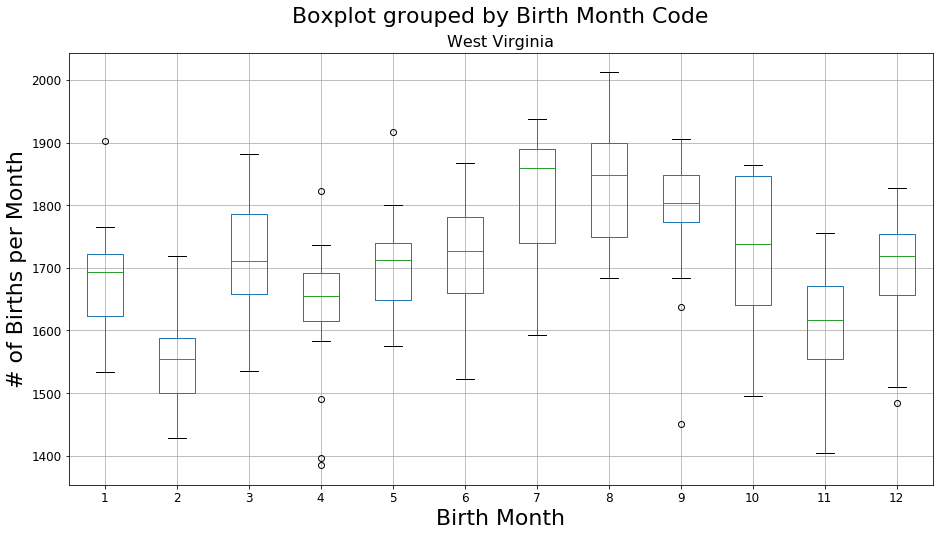

In [61]:
Random_Plotter_Boxplot(df, geography='state', metric='birth')

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 

### - 